# Homework 4

### Snow Hydrology

### Clinton Alden

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import datetime as dt
import altair as alt
from metpy.units import units
from metpy.constants import density_water
import pint_xarray

### Problem 1: Snowpack temperature profiles

In Lab4-1, we plotted vertical profiles of snowpack temperature on multiple, sequential days. Replicate these plots for all days from the first half of April (April 1–15). Find 4-5 days during this period where some significant behavior in the snowpack temperatures changes. Isolate the plots to only these 3-5 days. What is going on here? Why are the snowpack temperatures acting the way they are? Note: Please do not include plots for 15 days in your homework. Once you have found the "interesting behavior", only include plots that show these 3-5 days.

In [5]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

tsnow_vars = [v for v in sos_dataset if 'Tsnow_' in v and v.endswith('_d')]
snow_depth_vars = ['SnowDepth_d']

tsnow_vars = [
    'Tsnow_0_4m_d',
    'Tsnow_0_5m_d',
    'Tsnow_0_6m_d',
    'Tsnow_0_7m_d',
    'Tsnow_0_8m_d',
    'Tsnow_0_9m_d',
    'Tsnow_1_0m_d',
    'Tsnow_1_1m_d',
    'Tsnow_1_2m_d',
    'Tsnow_1_3m_d',
    'Tsnow_1_4m_d',
    'Tsnow_1_5m_d'
]
tsnow_data = sos_dataset[tsnow_vars]

tsnow_data = tsnow_data.to_dataframe()

<Axes: xlabel='time'>

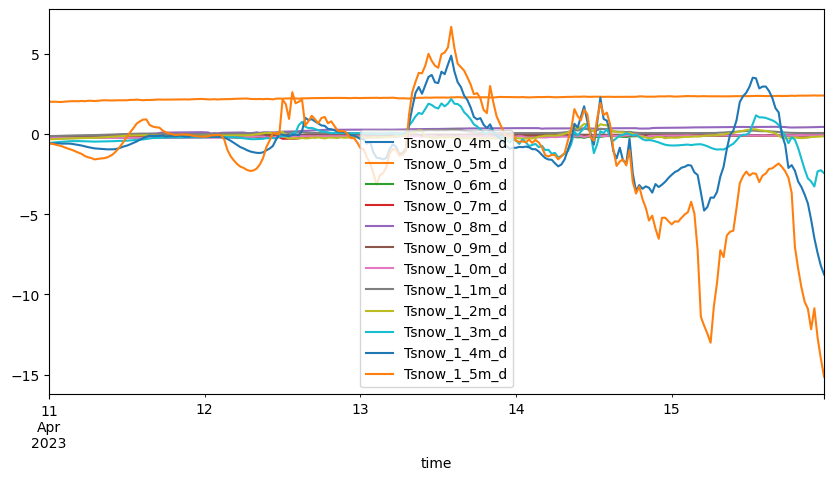

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

tsnow_data.loc['20230411': '20230415'].plot(ax=ax)

I highlighted above the period from 11 April to 15 April above. What we are seeing above is the result of snow melt or compaction which decreased snow depth. Now, some of the temperature sensors are air above the snow surface. We can see the 1.4m and 1.5m sensors in particular undergoing a large temperature range and seeing temperatures above 0C consistently, indicating the sensors are now measuring air temperatures. Additionally, the other sensors indicate an isothermal temperature profile which also supports the snow melt hypothesis.

### Problem 2: Snowpack internal energy

In Lab 4-2, we estimated the "change in snowpack internal energy" term by using an estimate of constant snowpack density. In Lab 4-3, we examined actual measurements of snow density from snowpits. In Lab 2-3, we examined estimates of snow density from snow-pillow SWE and snow depth measurements. Combining your knowledge from these labs, complete the following steps:

#### A. Using the snowpit dataset, calculate the depth-averaged snowpack density for each snowpit-day (i.e. you should have one density value for day in the snowpit dataset).

In [24]:
snowpit_ds = xr.open_dataset("../data/KettlePondsSnowPits.nc")

# snowpit_ds = snowpit_ds.sel(time = slice('20230206', '20230207'))
snowpit_df = snowpit_ds.to_dataframe().reset_index()

# The timestamps in this dataset are in UTC. Let's convert to US/Mountain time, which our other dataset is conveniently already in.
# After we convert, we remove the timezone info by calling `tz_localize(None)`. 
snowpit_df.time = snowpit_df.time.dt.tz_localize('UTC').dt.tz_convert('US/Mountain').dt.tz_localize(None)

# convert depth variables from cm to m
snowpit_df['depth'] = snowpit_df['depth']/100
snowpit_df['pit_total_snow_depth'] = snowpit_df['pit_total_snow_depth']/100

In [34]:
# Group by the date column and calculate the mean of the 'value' column
average_density = snowpit_df.groupby(snowpit_df['time'].dt.date)['density'].mean().reset_index()
average_density['time'] = pd.to_datetime(average_density['time'])
average_density.set_index('time', inplace=True)
average_density

,density
time,
2023-01-06,240.375000
2023-01-07,235.800000
2023-01-09,251.125000
2023-01-10,236.600000
2023-01-11,256.111111
2023-01-13,275.900000
2023-01-15,275.400000
2023-01-16,253.200000
2023-01-18,245.545455


#### B. Using the main sos dataset, calculate the daily-averaged, depth-averaged snowpack density (we did this in Lab 2-3).


In [28]:
snowdensity_c = (
    sos_dataset['SWE_p3_c']*units("mm")
).pint.to("m") * density_water / (
    sos_dataset['SnowDepth_c'] * units("m")
)

#### C. Plot the two time series of daily snowpack density from the two different datasets on the same plot.


/Users/clintonalden/miniforge3/envs/snow_hydro/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


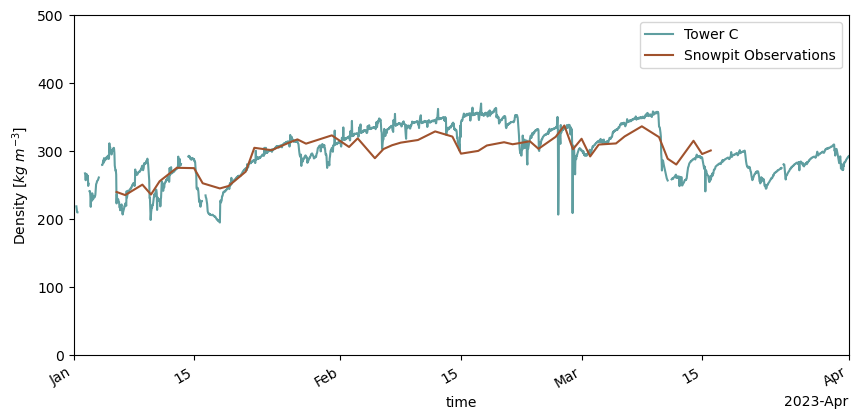

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))

snowdensity_c.plot(ax=ax, label='Tower C', color='cadetblue')
average_density['density'].plot(ax=ax, label='Snowpit Observations', color='sienna')

ax.set_ylabel("Density [$kg$ $m^{-3}$]")
ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-04-01'))
ax.set_ylim(0, 500)
ax.legend()


#### D. Describe the differences between the two. Describe how changes in snowpack density will result in a different estimate of the "change in snowpack internal energy term", assuming all other measurements stay the same. According to the equation below (copied from Lab 4-2), will increasing/decreasing density cause an estimate of the change-in-internal-energy term to increase or decrease?

$\frac{d}{dt}(\Delta z U) = \rho_s c^{ice}_p \Delta z \frac{d}{dt} \left\langle T_s \right\rangle$

In general, the two density time series match each other well. The main difference is that the snowpit observations are slightly lower than the Tower C data. This looks to be because the snowpits potentially undersampled the highest density part of the snowpack due to plants and brush at the bottom of those pits.

Referencing the equation above, the change in internal energy term will increase with higher density. The more density (and thus mass) in a snowpack, the more energy is required to change its temperature and internal energy.

### Problem 3: The snowpack energy balance (no coding or plotting)
According to your answer to Problem 2D, do you think that snow pit measurements of density will help "close" the snowpack energy balance, relative to estimates of density from snow pillows and snow depth senosrs (by close, I mean decrease the "residual" observed in the energy balance, as shown at the end of Lab 4-2). If someone is trying to "close" the snowpack energy balance, do you think that acquiring snow-pit measurements of snow density should be a high priority?

I do not think that snow pit density measurements will help close the energy balance. It may slightly decrease the unaccounted for energy but will not fully close the gap. The differences are small between bulk snow density measured from a snow pillow and depth sensor and density averaged over different depths from a snowpit. Ultimately, the depth integrated density is what is import for the energy balance and this small difference will have minimal impact. Snow pit density measurements are not a high priority for this purpose. (cool for other reasons though!!)

### Problem 4: Kinetic Growth Metamorphism (no coding or plotting)
In Week 2, we discussed how kinetic growth of crystals occurs when the within-snowpack temperature gradient exceeds 0.2˚C/cm. When this occurs, depth hoar is likely to grow. Using the two days of snow pit temperature profiles examined in Lab 4-3, estimate, by eye, the maximum temperature gradient observed in the snow pit, and report your estimate. If kinetic growth of crystals favored on either day? Where does the maximum temperature gradient occur?

### Problem 5: Behavior of temperatures above/below the snowpack (no coding or plotting)
In Lab 4-1, we first plotted a time series of temperatures measured by all the thermistors on tower d for February 15 - 18. Based on the behavior of the temperatures, can you determine which of the thermistors is above the snow surface and which is below the surface? Estimate the snow depth based on those plots, and explain how you came to this conclusion.